In [96]:
# request data from yahoo finance

import pandas as pd
from pandas_datareader import data as pdr
import numpy as np

import matplotlib as mpl

from matplotlib import style
import datetime
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from datetime import date, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


days = 252*4
ticker = 'TSLA'
start = str(date.today() - timedelta(days))
end = str(date.today())
stock = pdr.get_data_yahoo(ticker, start)

[*********************100%***********************]  1 of 1 completed


## Moving Average

In [97]:
#calculate the 30 moiving for price
stock['MA5'] = stock['Adj Close'].rolling(window = 5).mean()
stock['MA10'] = stock['Adj Close'].rolling(window = 10).mean()
stock['MA20'] = stock['Adj Close'].rolling(window = 20).mean()
stock['MA50'] = stock['Adj Close'].rolling(window = 50).mean()
# stock['MA200'] = stock['Adj Close'].rolling(window = 200).mean()
stock['next day open'] = stock['Open'].shift(-1).ffill() #add next day open column
stock = stock[stock['MA50'].notna()][:-1] # also drop the last row

In [98]:
stock.shape

(647, 11)

In [99]:
def getLRData(df,data, normalise=False, deci=4):
    features, labels = np.array(
        data[:, :10]), np.array(data[:, 10])
    labels = labels.reshape(len(labels), 1)
   
    dates = np.array(df.index)
    dates = dates.reshape(len(dates), 1)
    labelsMean, featuresMean = 1, np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
    if normalise == True:
        featuresMean = np.mean(features, axis=0, keepdims=True)
        labelsMean = np.mean(labels, keepdims=True)
        features, labels = (features/featuresMean), (labels/labelsMean)
        features, labels = np.round(features.astype(np.double), decimals=deci), np.round(
            labels.astype(np.double), decimals=deci)

    DMA5, DMA10, DMA20, DMA50 = features[:,0:7], features[:,[0,1,2,3,4,5,7]], features[:,[0,1,2,3,4,5,8]], features[:,[0,1,2,3,4,5,9]]
    result = {"dates": dates, "features":features, "5DMA": DMA5, "10DMA": DMA10,"20DMA": DMA20,"50DMA": DMA50, "labels": labels,
              "labelsMean": labelsMean, "featuresMean": featuresMean}
    return result
def convertNegative(data):
    for i in range(len(data)):
        if data[i] <0: 
            data[i]= np.array(0)



Accuracy for 5 DMA:99.09615775684402
RMSE with 5 DMA:0.018198087660159686

Accuracy for 10 DMA:99.09765177700811
RMSE with 10 DMA:0.018183041032969582

Accuracy for 20 DMA:99.08948669007373
RMSE with 20 DMA:0.01826512229678201

Accuracy for 50 DMA:99.093222150267
RMSE with 50 DMA:0.018227616661818692


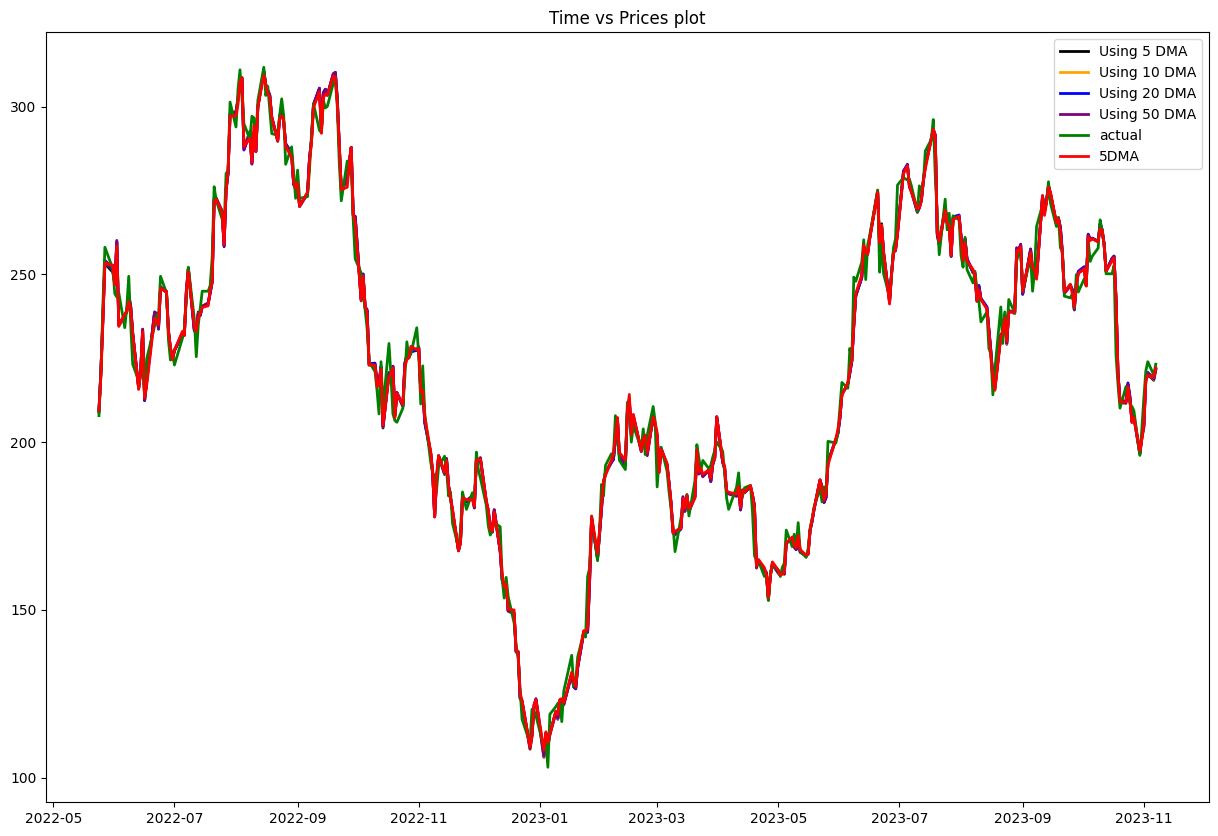

In [100]:


data = np.array(stock)
result = getLRData(stock, data, True, deci=3)
features, labels, dates = result["features"], result["labels"], result["dates"]

data_split = 280
# seperate features and labels for training and validation
train_features, test_features = features[:data_split], features[data_split:]
train_labels, test_labels = labels[:data_split], labels[data_split:]

# get 5 DMA model
DMA5 = LinearRegression()
DMA5.fit(train_features[:, 0:7], train_labels)
DMA5_pred = DMA5.predict(test_features[:, 0:7]) 
convertNegative(DMA5_pred)
# DMA5_pred = np.array(np.array(u) if u >= 0 else np.array(0) for u in DMA5_pred)
acc5 = DMA5.score(test_features[:, 0:7], test_labels)

# get 10 DMA model
DMA10 = LinearRegression()
DMA10.fit(train_features[:, [0,1,2,3,4,5,7]], train_labels)
DMA10_pred = DMA10.predict(test_features[:, [0,1,2,3,4,5,7]])
convertNegative(DMA10_pred)
# DMA10_pred = [u if u >= 0 else 0 for u in DMA10_pred]
acc10 = DMA10.score(test_features[:, [0,1,2,3,4,5,7]], test_labels)

# get 20 DMA model
DMA20 = LinearRegression()
DMA20.fit(train_features[:, [0,1,2,3,4,5,8]], train_labels)
DMA20_pred = DMA20.predict(test_features[:, [0,1,2,3,4,5,8]])
convertNegative(DMA20_pred)
# DMA20_pred = [u if u >= 0 else 0 for u in DMA20_pred if u >=0]
acc20 = DMA20.score(test_features[:, [0,1,2,3,4,5,8]], test_labels)

# get 50 DMA model
DMA50 = LinearRegression()
DMA50.fit(train_features[:, [0,1,2,3,4,5,9]], train_labels)
DMA50_pred = DMA50.predict(test_features[:, [0,1,2,3,4,5,9]])
convertNegative(DMA50_pred)
# DMA50_pred = [u if u >= 0 else 0 for u in DMA50_pred if u >=0]
acc50 = DMA50.score(test_features[:, [0,1,2,3,4,5,9]], test_labels)
# how to draw in the same graph???????
# get accuracy of the model
print("\nAccuracy for 5 DMA:"+str(acc5*100))
print("RMSE with 5 DMA:"+str(np.sqrt(mean_squared_error(test_labels, DMA5_pred))))
print("\nAccuracy for 10 DMA:"+str(acc10*100))
print("RMSE with 10 DMA:"+str(np.sqrt(mean_squared_error(test_labels, DMA10_pred))))
print("\nAccuracy for 20 DMA:"+str(acc20*100))
print("RMSE with 20 DMA:"+str(np.sqrt(mean_squared_error(test_labels, DMA20_pred))))
print("\nAccuracy for 50 DMA:"+str(acc50*100))
print("RMSE with 50 DMA:"+str(np.sqrt(mean_squared_error(test_labels, DMA50_pred))))

mpl.rc('figure', figsize=(15,10))
# plot actual, predicted and 5SMA values for test duration
plt.plot(dates[data_split:], result["labelsMean"]*DMA5_pred, linewidth=2, color="black")
plt.plot(dates[data_split:], result["labelsMean"]*DMA10_pred, linewidth=2, color="orange")
plt.plot(dates[data_split:], result["labelsMean"]*DMA20_pred, linewidth=2, color="blue")
plt.plot(dates[data_split:], result["labelsMean"]*DMA50_pred, linewidth=2, color="purple")
plt.plot(dates[data_split:], result["labelsMean"] *test_labels, color="green", linewidth=2)


plt.plot(dates[data_split:], ((result["featuresMean"].astype(float))
                       * features[data_split:])[:, 4], color="red", linewidth=2)
plt.legend(["Using 5 DMA","Using 10 DMA","Using 20 DMA","Using 50 DMA", "actual", "5DMA"])
plt.title("Time vs Prices plot")
plt.show()


In [101]:
# plt.plot(dates[data_split:], result["labelsMean"]*DMA5_pred, linewidth=2, color="black")
# plt.plot(dates[data_split:], result["labelsMean"] *test_labels, color="green", linewidth=2)

# plt.legend(["Using 5 DMA", "actual"])
# plt.title("Time vs Prices plot")
# plt.show()

In [102]:
# plt.plot(dates[data_split:], result["labelsMean"]*DMA20_pred, linewidth=2, color="blue")
# plt.plot(dates[data_split:], result["labelsMean"] *test_labels, color="green", linewidth=2)
# plt.plot(dates[data_split:], ((result["featuresMean"].astype(float))
#                        * features[data_split:])[:, 4], color="red", linewidth=2)

# plt.legend(["Using 20 DMA", "actual", "5DMA"])
# plt.title("Time vs Prices plot")
# plt.show()

In [103]:
# plt.plot(dates[data_split:], result["labelsMean"]*DMA50_pred, linewidth=2, color="purple")
# plt.plot(dates[data_split:], result["labelsMean"] *test_labels, color="green", linewidth=2)
# plt.plot(dates[data_split:], ((result["featuresMean"].astype(float))
#                        * features[data_split:])[:, 4], color="red", linewidth=2)

# plt.legend(["Using 50 DMA", "actual", "5DMA"])
# plt.title("Time vs Prices plot")
# plt.show()

## AutoRegressive Integrated Moving Average

In [104]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

stock

,Open,High,Low,Close,Adj Close,Volume,MA5,MA10,MA20,MA50,next day open
Date,,,,,,,,,,,
2021-04-15,247.699997,247.896667,240.436661,246.283340,246.283340,83546700,240.826669,233.719667,224.266499,236.643799,242.883331
2021-04-16,242.883331,249.803329,241.533340,246.593338,246.593338,83938500,245.010669,236.320668,225.710166,235.877733,239.866669
2021-04-19,239.866669,241.800003,230.600006,238.210007,238.210007,119058600,245.854004,237.106668,226.706167,234.975333,239.139999
2021-04-20,239.139999,245.750000,236.896667,239.663330,239.663330,106827000,242.965335,238.019002,227.522667,234.087067,234.923340
2021-04-21,234.923340,248.279999,232.666672,248.039993,248.039993,93646500,243.758002,240.457335,228.888667,233.291733,247.166672
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,204.039993,205.990005,197.850006,205.660004,205.660004,121661700,203.384000,209.004001,232.916999,245.469199,212.970001
2023-11-02,212.970001,219.199997,211.449997,218.509995,218.509995,125987600,205.934000,208.844000,230.839999,245.102199,221.149994
2023-11-03,221.149994,226.369995,218.399994,219.960007,219.960007,119281000,208.466000,209.641000,228.811500,244.900599,223.979996


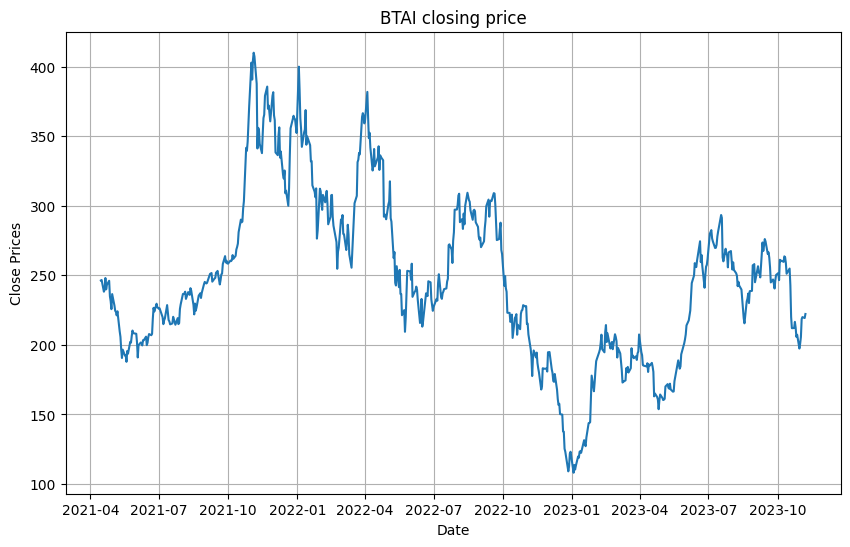

In [105]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock['Close'])
plt.title('BTAI closing price')
plt.show()

<Axes: ylabel='Density'>

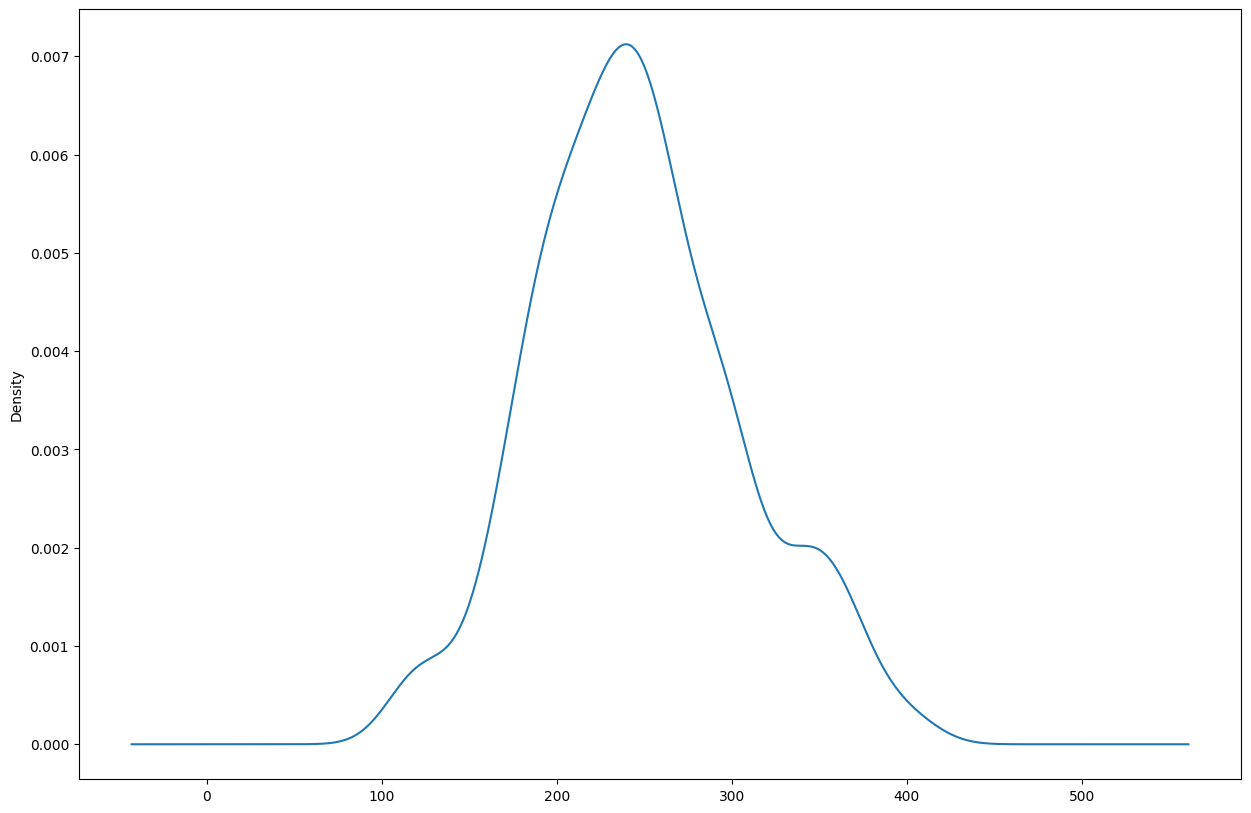

In [106]:
#Distribution of the dataset
df_close = stock['Close']
df_close.plot(kind='kde')


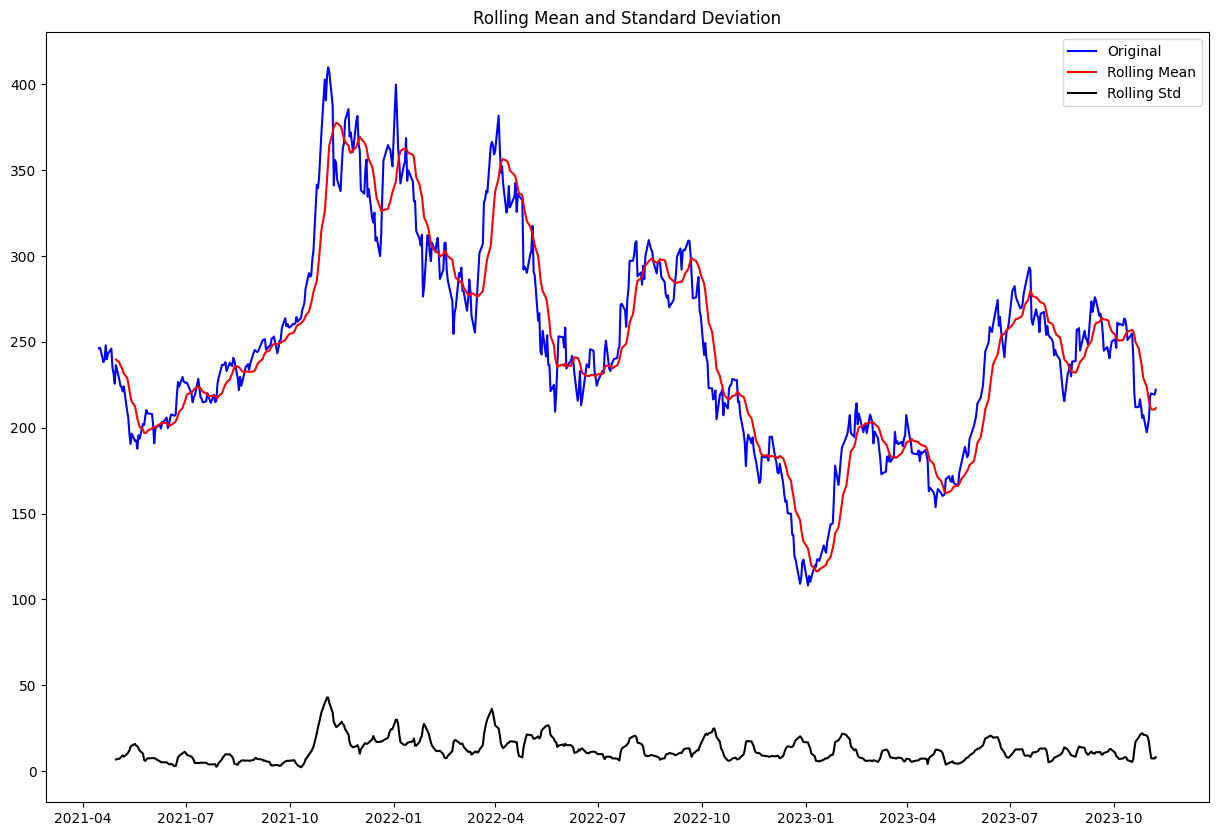

Results of dickey fuller test
Test Statistics                 -2.362671
p-value                          0.152550
No. of lags used                 9.000000
Number of observations used    637.000000
critical value (1%)             -3.440657
critical value (5%)             -2.866088
critical value (10%)            -2.569192
dtype: float64


In [107]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 1500x1000 with 0 Axes>

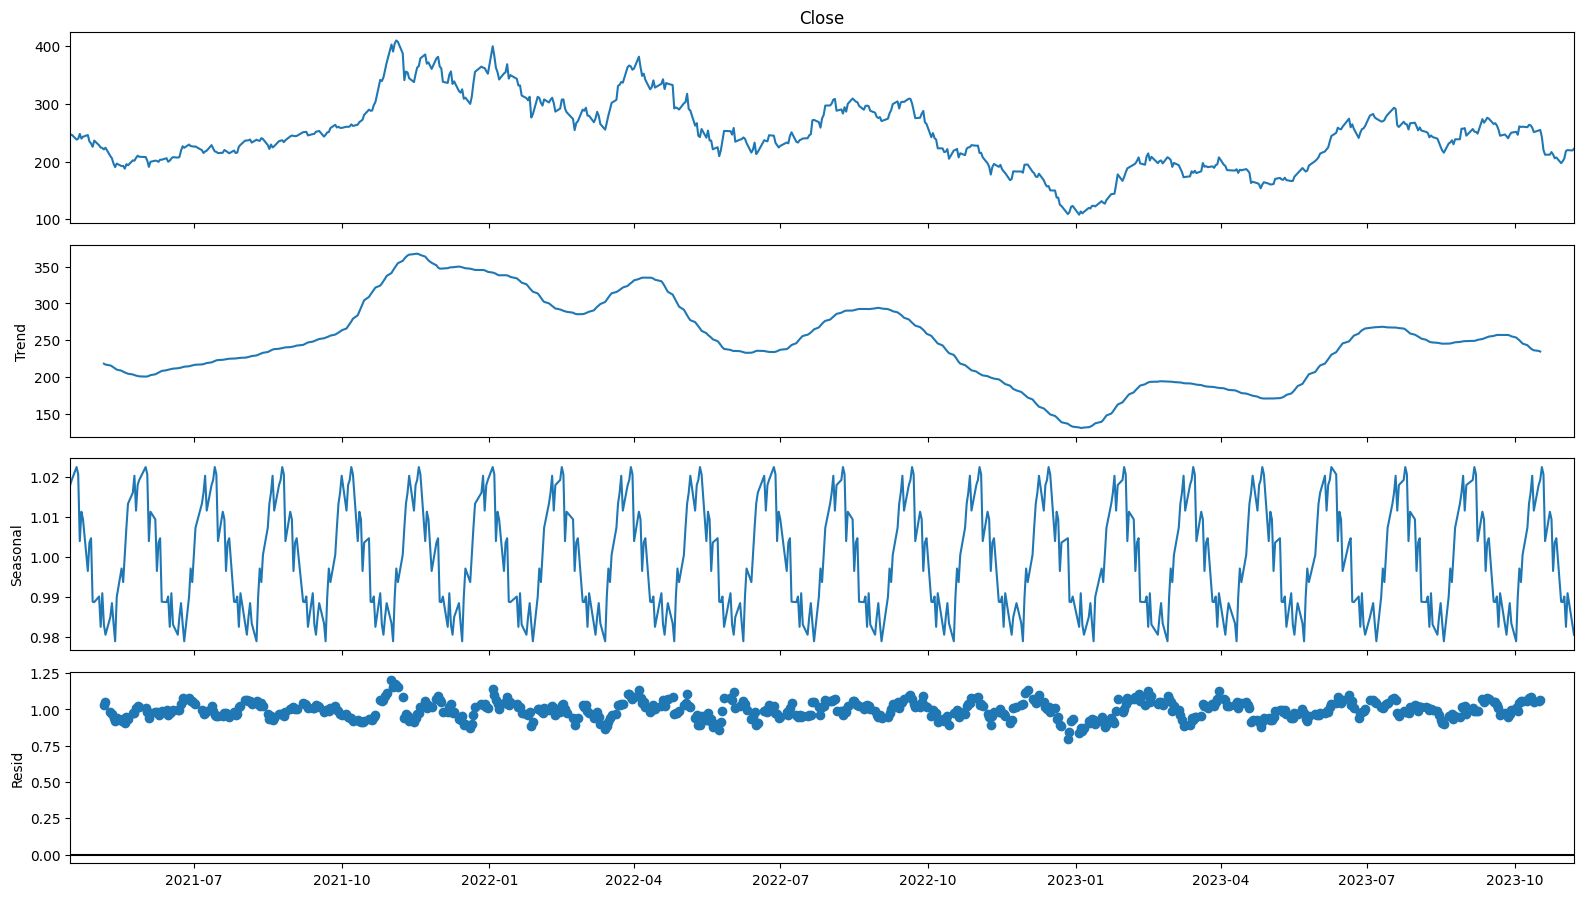

In [108]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code

result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


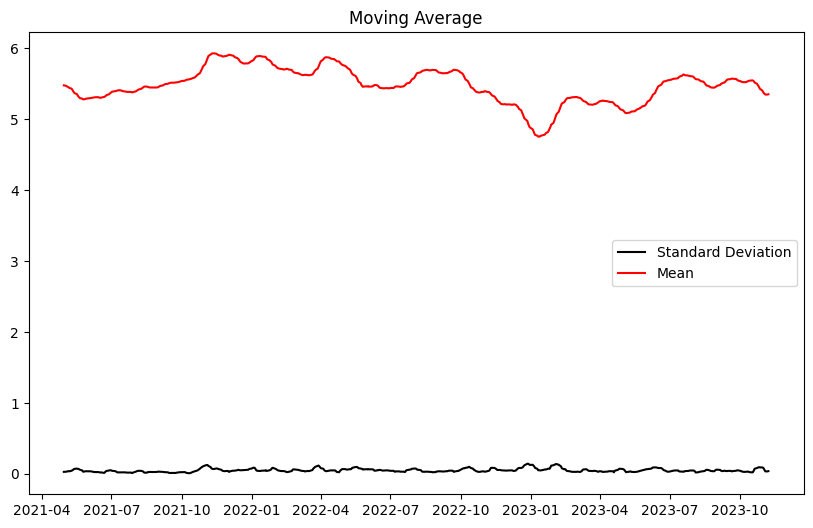

In [109]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

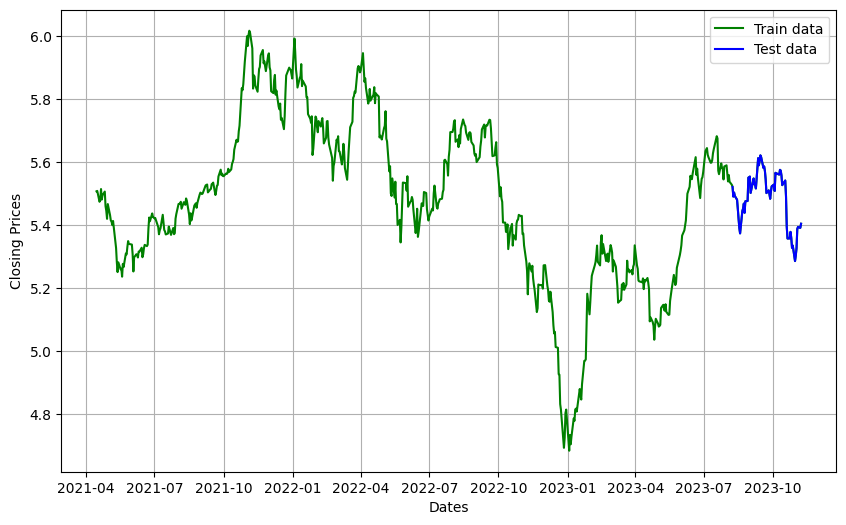

In [110]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2156.954, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2155.429, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2155.400, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2158.951, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2154.481, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.488 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  579
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1080.476
Date:                Wed, 08 Nov 2023   AIC                          -2158.951
Time:                        16:48:59   BIC                          -2154.592
Sample:                             0   HQIC                         -2157.252
                                - 579                                  

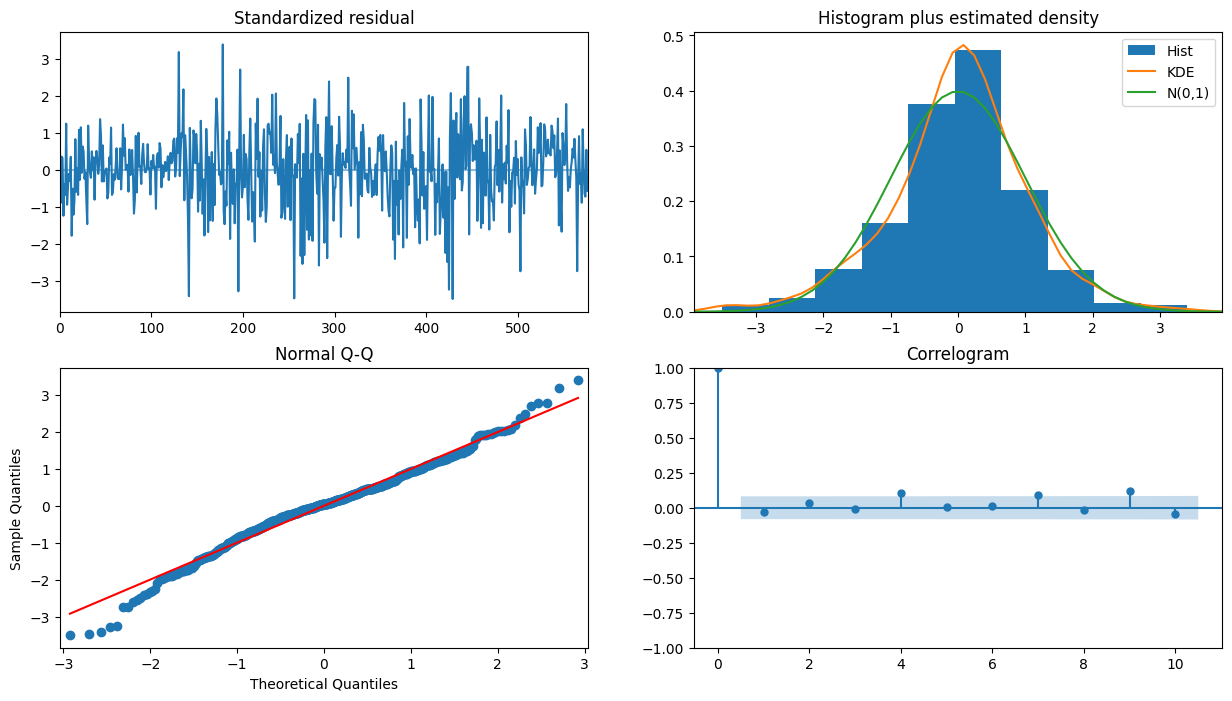

In [111]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [112]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  579
Model:                 ARIMA(1, 1, 2)   Log Likelihood                1080.963
Date:                Wed, 08 Nov 2023   AIC                          -2153.926
Time:                        16:49:00   BIC                          -2136.488
Sample:                             0   HQIC                         -2147.126
                                - 579                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0394      1.485     -0.027      0.979      -2.949       2.870
ma.L1          0.0130      1.482      0.009      0.993      -2.892       2.918
ma.L2          0.0293      0.054      0.542      0.5

In [122]:
dic = {'pred':[]}
for i in range(65):
    dic["pred"].append(fitted.forecast(65, alpha=0.05)[fitted.forecast(70, alpha=0.05).index[i]])
fc_series = pd.DataFrame(dic, index = test_data.index)

In [123]:
min(fc_series['pred']), max(fc_series['pred'])

(5.5265944574330215, 5.526895023373246)

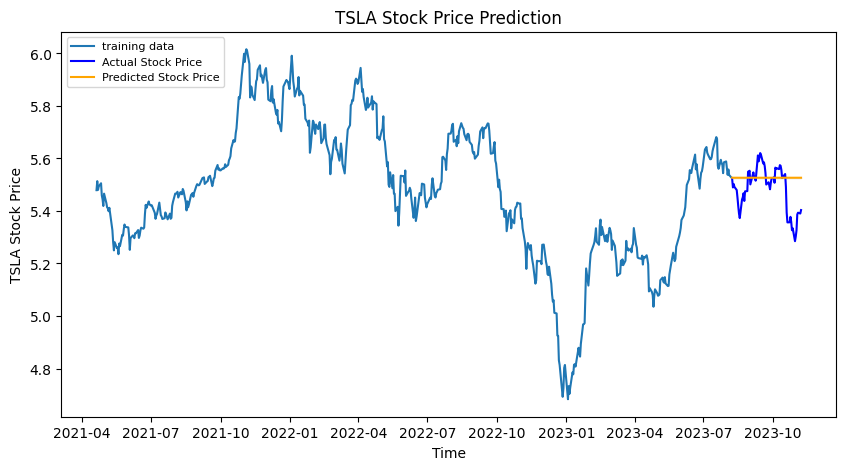

In [124]:
# Forecast
fc = fitted.forecast(70, alpha=0.05)  # 95% conf
# Make as pandas series
# fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(min(fc_series['pred']), index=test_data.index)
upper_series = pd.Series(max(fc_series['pred']), index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('TSLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TSLA Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()